<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment2/MachineLearningAssignment2SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libraries and Data in

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', sep='\t', delimiter=None, header='infer', names=None, index_col=None)

Saving Sentiment140.tenPercent.sample.tweets.tsv to Sentiment140.tenPercent.sample.tweets (3).tsv


# Data Exploration

Check Size of Data

In [5]:
print(data.head())
print(data.info())

   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


Check if any missing values

In [6]:
print(data.isnull().values.any())

False


In [7]:
df = data
df.rename(columns = {'sentiment_label':'target'}, inplace = True)

print("Number of duplicates before dropping:  " + str(len(df[df.duplicated()])))

df.drop_duplicates(keep = False, inplace = True)
print("Number of duplicates after dropping:  " + str(len(df[df.duplicated()])))

Number of duplicates before dropping:  553
Number of duplicates after dropping:  0


Checking if data balanced

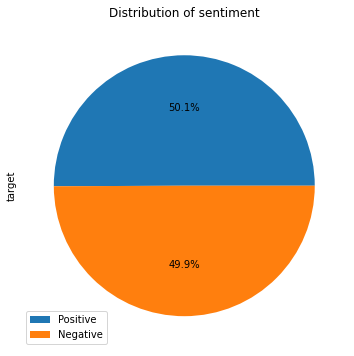

In [8]:
df['target'] = df['target'].replace(4,1)

df['target'].value_counts().plot.pie(figsize=(6,6),title="Distribution of sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

# Data Pre-processing

In [9]:
data_pos = df[df['target'] == 1]
data_neg = df[df['target'] == 0]

data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

dataset = pd.concat([data_pos, data_neg])

In [10]:
dataset['tweet_text']=dataset['tweet_text'].str.lower()
dataset['tweet_text'].tail()

40140    im haven my pc upgraded 2day so i wont be twit...
40143    @preludebabe hey hun,  no i never did  i would...
40145    @icobee most of my blockmates enlisted in hist...
40148                   @amaretto_87 what's wrong boo???? 
40149    the recording last night was sounding sweet, c...
Name: tweet_text, dtype: object

In [11]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [12]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda text: cleaning_stopwords(text))
dataset['tweet_text'].head()

0     @elephantbird hey dear, happy friday already r...
1      ughhh layin downnnn waiting zeina cook breakfast
6                     god ur side anything possible....
10                     video vh1 much better u tube one
14    @ ashleyltmsyf hey ashley hush hush; hush hush...
Name: tweet_text, dtype: object

In [13]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['tweet_text']= dataset['tweet_text'].apply(lambda x: cleaning_punctuations(x))
dataset['tweet_text'].tail()

40140    im haven pc upgraded 2day wont twittering next...
40143    preludebabe hey hun no never would love know b...
40145    icobee blockmates enlisted histo 16 naubusan k...
40148                           amaretto87 whats wrong boo
40149    recording last night sounding sweet cant wait ...
Name: tweet_text, dtype: object

In [14]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: cleaning_repeating_char(x))
dataset['tweet_text'].tail()

40140    im haven pc upgraded 2day wont twittering next...
40143    preludebabe hey hun no never would love know b...
40145    icobee blockmates enlisted histo16 naubusan ka...
40148                           amaretto87 whats wrong boo
40149    recording last night sounding sweet cant wait ...
Name: tweet_text, dtype: object

In [15]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: cleaning_URLs(x))
dataset['tweet_text'].tail()

40140    im haven pc upgraded 2day wont twittering next...
40143    preludebabe hey hun no never would love know b...
40145    icobee blockmates enlisted histo16 naubusan ka...
40148                           amaretto87 whats wrong boo
40149    recording last night sounding sweet cant wait ...
Name: tweet_text, dtype: object

In [16]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: cleaning_numbers(x))
dataset['tweet_text'].tail()

40140    im haven pc upgraded day wont twittering next ...
40143    preludebabe hey hun no never would love know b...
40145    icobee blockmates enlisted histo naubusan kasi...
40148                             amaretto whats wrong boo
40149    recording last night sounding sweet cant wait ...
Name: tweet_text, dtype: object

In [17]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize 

dataset['tweet_text'] = dataset['tweet_text'].apply(word_tokenize)
dataset['tweet_text'].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0     [elephantbird, hey, dear, happy, friday, alrea...
1     [ughhh, layin, downnnn, waiting, zeina, cook, ...
6                   [god, ur, side, anything, possible]
10               [video, v, much, better, u, tube, one]
14    [ashleyltmsyf, hey, ashley, hush, hush, hush, ...
Name: tweet_text, dtype: object

In [18]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['tweet_text']= dataset['tweet_text'].apply(lambda x: stemming_on_text(x))
dataset['tweet_text'].head()

0     [elephantbird, hey, dear, happy, friday, alrea...
1     [ughhh, layin, downnnn, waiting, zeina, cook, ...
6                   [god, ur, side, anything, possible]
10               [video, v, much, better, u, tube, one]
14    [ashleyltmsyf, hey, ashley, hush, hush, hush, ...
Name: tweet_text, dtype: object

In [19]:
import nltk
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['tweet_text'] = dataset['tweet_text'].apply(lambda x: lemmatizer_on_text(x))
dataset['tweet_text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0     [elephantbird, hey, dear, happy, friday, alrea...
1     [ughhh, layin, downnnn, waiting, zeina, cook, ...
6                   [god, ur, side, anything, possible]
10               [video, v, much, better, u, tube, one]
14    [ashleyltmsyf, hey, ashley, hush, hush, hush, ...
Name: tweet_text, dtype: object

Creating word clouds...


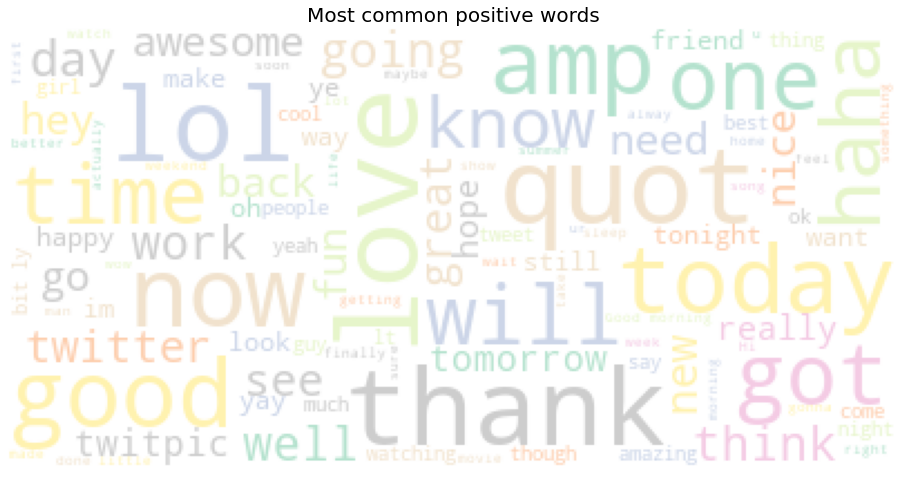

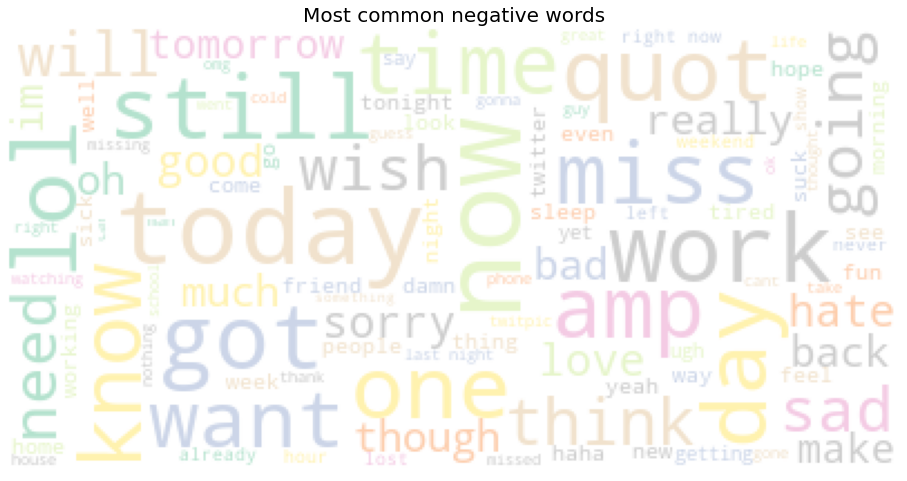

In [20]:
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(words,sentiment):
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')

print("Creating word clouds...")
positive_words=" ".join(df[df.target==1]['tweet_text'].values)
negative_words=" ".join(df[df.target==0]['tweet_text'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")


# Machine Learning

In [21]:
X=df.tweet_text
y=df.target

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [23]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [24]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [25]:
def model_Evaluate(model):
# Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['TN  ','FP ', 'FN ','TP ']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [29]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['BernoulliNB'] = BernoulliNB()
models['Support Vector Machines'] = LinearSVC()
models['Logistic Regression'] = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier model
    models[key].fit(X_train, y_train)
    
    # Prediction 
    predictions = models[key].predict(X_test)
    
    # Calculate Accuracy, Precision and Recall Metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

In [31]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
BernoulliNB,0.781702,0.784701,0.777415
Support Vector Machines,0.795275,0.791540,0.794963
Logistic Regression,0.801433,0.798886,0.800508


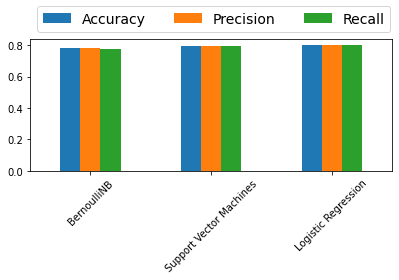

In [32]:
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 14})
plt.tight_layout()